## This is a script to stack VANDELS spectra

The following steps are carried out to perform the stacking:
- Point to a folder containing fits files and read in the spectra
- Convert the spectra to rest frame using the redshift value given in the header file
- Create a rest-frame wavelength grid assuming a median wavelength on to which individual spectra would be resampled
- Perform a weighted average of the spectra, where the weights are based on the errors on the individual spectra
- Propagate the errors and save the stacked spectrum along with the errors!


Python packages required for essential functions:
- numpy
- astropy
- mpdaf (pip/pip3 install mpdaf)
- matplotlib (for plotting)
- math (for statistics) 

Additionally, to make life easier it is also useful to place the mpvandels.py file in the same folder as this notebook. This custom python package helps read in the spectra and easily convert them to rest-frame

In [58]:
import numpy as np
from astropy.io import fits
from astropy.table import Table

from astropy.stats import sigma_clipped_stats

import os
import glob
import matplotlib.pyplot as plt

import mpdaf as mp
import astropy.units as u

import math

import mpvandels as mpv
from mpdaf.obj import Spectrum, WaveCoord

### Define restframe wavelengths and then redshift them for fitting
### Selected lines only

rest_lines = np.array([1215.24, 1240.81, 1262., 1302., 1335.31, 1402.8, 1549.6, 1640.4, 1666., 1892., 1908.], dtype=float)
linewidths = np.array([50, 20, 25, 10, 15, 5, 15, 20], dtype=float)

line_names = ['Lya', 'NV', 'SiII', 'OI', 'CII', 'SiIV', 'CIV', 'HeII', 'OIII]','SiIII]', 'CIII]']

In [69]:
### Define source director with all the spectra
SUBSET = 'lae4'

SPEC_DIR = "/Users/aayushsaxena/Desktop/UCL/XRB-VANDELS-project/CDFS-Xray-spectra/subset_%s/" %SUBSET
os.chdir(SPEC_DIR)


### Define arrays to append individual spectra and properties
spectra = []
# errors = []
weights = []

### Flux at 1500A used to normalise
FUV = []
### Redshift
ztar = []

### Keep track of number of sources
sourcecounter = 0

speclist = glob.glob("*.fits")
for spec in speclist:
    specdata, z, snr = mpv.readvandels(spec) ### Read in the observed frame spectrum and redshift
    restspec = mpv.restframespec(spec, z) ### convert to rest frame
    
    ### append z info to be used later for resampling
    ztar.append(z)
    
    ### Normalisation
    fUV = np.nanmean(restspec.subspec(lmin=1460, lmax=1520, unit=u.Angstrom).data)
    ### Measure variance in the region around 1500 A to determine error on the spectrum
    fuv_var = np.nanstd(restspec.subspec(lmin=1460, lmax=1520, unit=u.Angstrom).data)
    specvar = fuv_var/fUV
    
    ### Normalise the spectrum using flux at ~1500 A
    restspec.data = restspec.data/fUV
    # restspec.var = restspec.var/fUV
    
    ### append spectrum and errors to a list
    spectra.append(restspec)
    # errors.append(restspec.var)
    
    ### Append UV flux and weights
    FUV.append(fUV)
    weights.append(specvar)
    
    sourcecounter+=1
    
print("%d sources read in!" %sourcecounter)


### choose the cdelta value of the new wavelength grid based on the median redshift of the sample to be stacked
### calculate median z from all the redshifts of individual sources
zmed = np.median(ztar)
print("Median z = ", zmed)

### Define the cdelta value (using the CDELTA in the observed frame)
b=2.55299997329712/(1+zmed) # cdelt normalised to the mean redshift

print("CDELT = ", b, "for new wavelength array defined!")

8 sources read in!
Median z =  4.32775
CDELT =  0.47918914613056546 for new wavelength array defined!


In [70]:
### Resampling and stacking the spectra

### Starting wavelength (assuming that good VIMOS coverage begins at 5000A)
start_wav = 5100/(1+zmed)

### Define empty arrays to append fluxes and weights, calculated from the error spectrum
stackfluxes = []
stackweights = []

for i in range(len(spectra)):
    ### Resample the Spectrum object to the new wavelength grid
    specs = spectra[i]   
    weight = weights[i]
    
    ### resample the spectrum using the wavelength step of the median redshift, starting from 1200 A
    specs = specs.resample(step=b, start=start_wav, shape=1387, unit=u.Angstrom)
    
    ### Replace NaNs with zeros in case there is no wavelength coverage for certain sources
#     where_are_NaNs = np.isnan(specs.data)
#     specs.data[where_are_NaNs] = 0.
    
#     specs.var[where_are_NaNs] = 0.

    ### Mask the array values that have NaNs as a result of incomplete wavelength coverage
    specs.data = np.ma.masked_array(specs.data, np.isnan(specs.data))
    
    ### Mask the array values that have bad sky subtraction
    ### Iterate over spectrum pixels and mask 20 sigma outliers
    try:
        mean, med, std = sigma_clipped_stats(specs.data, sigma=3)
    
        spec_mask = np.zeros(len(specs.data))
        for j in range(len(specs.data)):
            if abs(specs.data[j]) > med + 20*std:
                specs[j] = 1

        specs.data = np.ma.masked_array(specs.data, spec_mask)
        
    except ValueError:
        print(specs, "skylines could not be masked")
            
    ### Append the fluxes and weights. Weights = 1/(err^2)
    stackfluxes.append(specs.data)
    stackweights.append(weight)
    
stackfluxes = np.array(stackfluxes)
stackweights = np.array(stackweights)
        
        
### replace NaNs in the weights
for i in range(len(stackweights)):
    if math.isnan(stackweights[i]):
        stackweights[i] = 0.

        
### Stack. This is done by weighted averaging of the fluxes. The weights are stored in the stackweights array
medflux = np.ma.average(stackfluxes, axis=0, weights=1/np.square(stackweights))

### Stack the error spectra
### Use the second moment of the spectrum to calculate weighted error
# med_error = np.sqrt(np.ma.average(np.square(stackfluxes), axis=0, weights=1/np.square(stackweights))
#                     -np.square(medflux))


### Guaita error prescription
med_error = np.sqrt(np.sum(np.square(stackfluxes*stackweights[:, np.newaxis]), axis=0))/len(stackfluxes)

### Calculated the stacked S/N by dividing the stacked flux by sqrt(N)
# stack_snr = np.median(weights) * np.sqrt(sourcecounter)
# med_error = medflux/stack_snr

print("Average SNR of spectra: ", np.average(1/stackweights))


### Calculate the median FUV of the stacked spectrum, which can be multiplied to the spectrum to normalise to flux
med_FUV = np.nanmedian(FUV)

### Define the stacked spectrum using the new wavelength grid. Also record the error spectrum
stackedwave = WaveCoord(crval=start_wav, cdelt=b, cunit=u.Angstrom)
stackedspec = Spectrum(wave=stackedwave, data=medflux, var=med_error)
err_stackedspec = Spectrum(wave=stackedwave, data=med_error)

print("SNR of the stacked spectrum: ", 
      np.nanmean(stackedspec.subspec(lmin=1460, lmax=1520, unit=u.Angstrom).data)/
      np.nanstd(stackedspec.subspec(lmin=1460, lmax=1520, unit=u.Angstrom).data))

print("Total number of sources in the bin: ", len(stackfluxes))

print("Stacking complete!")


Average SNR of spectra:  1.720470774957962
SNR of the stacked spectrum:  9.126096131460056
Total number of sources in the bin:  8
Stacking complete!


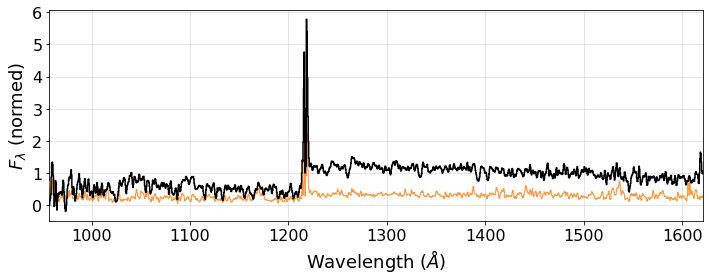

In [71]:
### Show stacked spectrum
%matplotlib inline

fig = plt.figure(figsize=(10,4))
plt.grid(alpha=0.4)

### Show stacked spectrum
stackedspec.plot(c='k',linewidth=1.5, zorder=10)
### Show error spectrum
err_stackedspec.plot(c='C1', alpha=0.8, zorder=8)

plt.xlabel(r"Wavelength ($\AA$)", fontsize=18)
plt.ylabel(r"$F_\lambda$ (normed)", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# plt.yscale('log')
# plt.ylim(0,2.0)

plt.tight_layout()

plt.savefig("/Users/aayushsaxena/Desktop/UCL/XRB-VANDELS-project/CDFS-Xray-spectra/STACKED_SPECTRA/subset_%s_stack.png" %SUBSET,
                 facecolor='w', dpi=200)

plt.show()

In [72]:
### If happy with the results, save the stacked spectrum
### The spectrum is saved as a MPDAF object, and can be easily read in using MPDAF
### The spectrum is also saved as a normal 1D fits file with error information, so can in principle be read
### using tools other than MPDAF as well.

stackedspec.write("/Users/aayushsaxena/Desktop/UCL/XRB-VANDELS-project/CDFS-Xray-spectra/STACKED_SPECTRA/subset_%s_stack.fits" %SUBSET)


In [73]:
### Little program to write out the spectrum information to a text file

hdu_data = fits.open("/Users/aayushsaxena/Desktop/UCL/XRB-VANDELS-project/CDFS-Xray-spectra/STACKED_SPECTRA/subset_%s_stack.fits" %SUBSET)

flux = hdu_data[1].data
var = hdu_data[2].data

crval = hdu_data[1].header["CRVAL1"]
cdelt = hdu_data[1].header["CDELT1"]
n = hdu_data[1].header["NAXIS1"]

### Wavelength
wave = np.zeros(n)
wave[0] = crval
for i in range(1, len(wave)):
    wave[i] = wave[i-1] + cdelt
    
f = open("/Users/aayushsaxena/Desktop/UCL/XRB-VANDELS-project/CDFS-Xray-spectra/STACKED_SPECTRA/subset_%s_spectrum.txt" %SUBSET, 'w')

for i in range(len(wave)):
    f.write("%.4f\t%.4f\t%.4f\n" %(wave[i], flux[i], var[i]))
    
f.close()